# **`Project 3: Team Mary Paley`**

### **Objective**: ...

#### Group Members:
> Emily Wu: wuemily@berkeley.edu <br>
> Rania Nasser: ...@berkeley.edu <br>
> Jing Huang: ...@berkeley.edu <br>
> Carmen Vega: carmenvega@berkeley.edu <br>
> Mario Zhao: mario.zhao@berkeley.edu <br>

### **[A]: Choice of a population, with supporting expenditure data**

In [169]:
#Importing
!pip install -r requirements.txt
%pip install python-gnupg
%pip install eep153_tools
%matplotlib inline
from eep153_tools.sheets import read_sheets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cfe
from cfe import Regression

import warnings
warnings.simplefilter("ignore")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [261]:
#Prices
ugd_p0 = pd.read_csv('Data Files/Uganda - Food Prices (2015-16).csv')
ugd_p = pd.pivot_table(ugd_p0, values="price", index=["j","u"], columns=["t","m"] , aggfunc="median")
#Food Expenditures
ugd_x0 = pd.read_csv('Data Files/Uganda - Food Expenditures (2015-16).csv')
ugd_x = pd.pivot_table(ugd_x0, values="Expenditure", index=["i","t","m"], columns="j" , aggfunc="median")
#Consumption
ugd_x_long = ugd_x.stack().reset_index(name="Expenditure")  # Ensure values are in a column
ugd_p_long = ugd_p0
ugd_c = ugd_x_long.merge(ugd_p_long, on=["j", "t", "m"], how="left")
ugd_c["Consumption"] = ugd_c["Expenditure"] / ugd_c["price"]
ugd_c = ugd_c.pivot_table(values="Consumption", index=["i","t","m","u"], columns="j", aggfunc="sum")
#HH Characteristics
ugd_z = pd.read_csv('Data Files/Uganda - Household Characteristics.csv')
ugd_z = ugd_z[ugd_z['t'] == '2015-16']
ugd_z = ugd_z.set_index(['i','t','m'])
ugd_z.fillna(0, inplace=True)
ugd_z.columns.name = 'k'

### **[B]: Nutritional content of different foods**

In [278]:
#FCT
ugd_fct = pd.read_csv('Data Files/Uganda - FCT.csv')
ugd_fct = ugd_fct.rename(columns={"index":"j"}).set_index(["j"])
ugd_fct.columns.name = 'n'
#RDI
ugd_rdi = pd.read_csv('Data Files/Uganda - RDA.csv')
ugd_rdi = ugd_rdi.set_index(["n"])
ugd_rdi.columns.name = 'k'

### **[A]: Estimate demand system**

Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.

In [279]:
ugd_result = cfe.Regression(y=np.log(ugd_x.stack()),d=ugd_z)

In [280]:
ugd_result.predicted_expenditures()

i         t        m        j                     
H0010101  2015-16  Central  Avocado                    2120.278738
                            Beans (dry)                4105.498331
                            Beef                      12544.220045
                            Bread                      4801.357482
                            Cabbage (green)            1298.877329
                                                          ...     
H4301001  2015-16  Western  Sugar                      1931.748348
                            Sweet Bananas              1879.396409
                            Sweet Potatoes (fresh)     4951.522520
                            Tea                         277.147138
                            Tomatoes                   1413.773727
Length: 116240, dtype: float64

<Axes: xlabel='yhat', ylabel='y'>

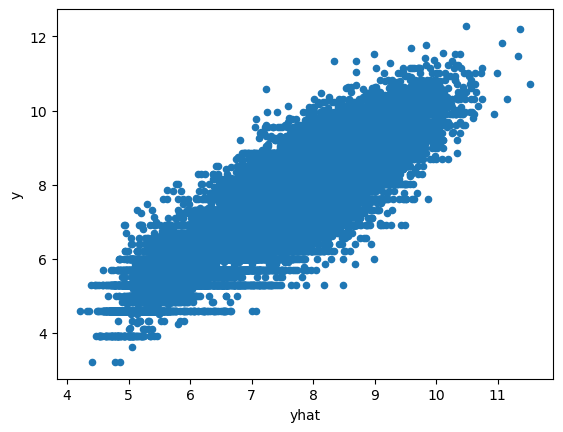

In [281]:
#Expenditures x may have duplicate columns
x1 = ugd_x0.groupby(['i','t','m','j']).sum()
#Replace zeros with missing values
x1 = x1.replace(0,np.nan)
#Take logs of expenditures; call this y
y = np.log(x1["Expenditure"])
#Create dataframe with predicted yhat values
ugd_acc = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
#Plot yhat vs y (predicted vs actual)
ugd_acc.plot.scatter(x='yhat',y='y')

In [282]:
ugd_result.R2(summary=True)

0.7647026613552443

In [283]:
#Save result
ugd_result.to_pickle('./Uganda.rgsn')
##To access result:
#import cfe
#result = cfe.regression.read_pickle('Uganda.rgsn')

### Parameters

**(Relative) Income Elasticity:** $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.

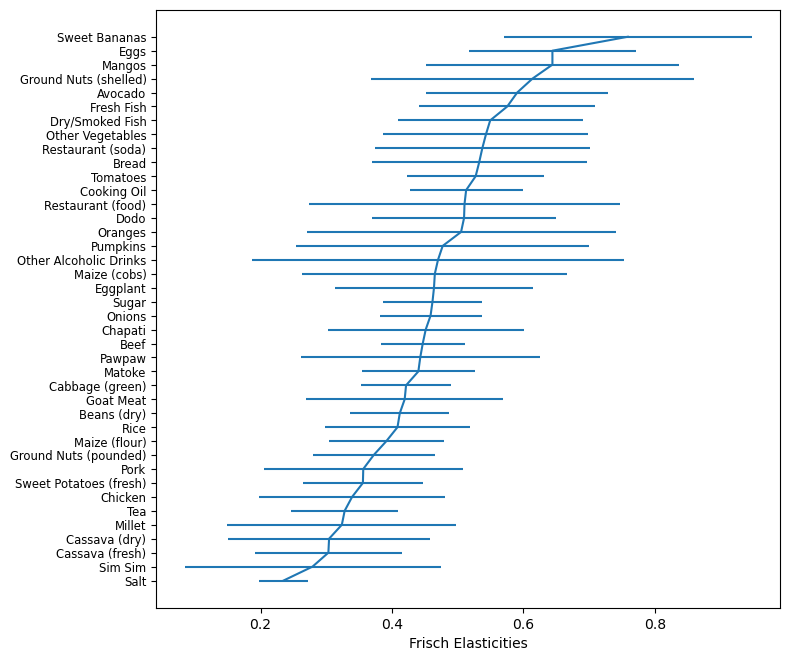

In [284]:
ax1 = ugd_result.graph_beta()

In [285]:
ugd_result.get_beta().sort_values(ascending=False)

j
Sweet Bananas             0.758686
Eggs                      0.644007
Mangos                    0.643999
Ground Nuts (shelled)     0.613713
Avocado                   0.590436
Fresh Fish                0.575306
Dry/Smoked Fish           0.549308
Other Vegetables          0.542870
Restaurant (soda)         0.537317
Bread                     0.532594
Tomatoes                  0.527233
Cooking Oil               0.512723
Restaurant (food)         0.510261
Dodo                      0.509566
Oranges                   0.505023
Pumpkins                  0.477064
Other Alcoholic Drinks    0.469921
Maize (cobs)              0.465099
Eggplant                  0.463826
Sugar                     0.461555
Onions                    0.458608
Chapati                   0.451228
Beef                      0.446730
Pawpaw                    0.442911
Matoke                    0.440056
Cabbage (green)           0.421318
Goat Meat                 0.419251
Beans (dry)               0.411784
Rice              

**Demand and Household Composition:** $\gamma_j$ parameters in the regression, which capture the effects of household composition on demand

In [286]:
ugd_result.get_gamma()

k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+,Constant
j,,,,,,,,,,,,,,,
Avocado,-0.001749,0.053157,0.097788,0.070099,0.044749,0.109250,0.109500,-0.039811,0.116493,0.110554,0.099206,0.125851,0.154415,0.172024,7.110684
Beans (dry),0.060985,0.009952,0.123259,0.067322,0.116112,0.136568,0.186018,0.040876,0.077162,0.145801,0.109049,0.095977,0.124109,0.197173,8.188212
Beef,-0.071094,0.060491,0.048143,0.062612,0.078594,0.105187,0.134416,-0.083635,0.090468,0.041827,0.024850,0.102250,0.121992,0.155326,9.078483
Bread,-0.245408,0.014262,0.059235,0.100455,0.134228,0.079356,0.074879,-0.044298,0.057761,0.013945,0.045761,0.121172,0.238776,0.182150,7.959559
Cabbage (green),0.017850,0.035405,0.049778,0.099048,0.054841,0.078428,0.126537,0.037837,0.005752,0.085192,0.043475,0.078816,0.127740,0.137220,7.034905
Cassava (dry),0.108581,0.003883,0.053185,0.027161,0.062756,0.127383,0.208950,0.039947,0.157590,0.047670,0.168352,0.107127,0.073177,-0.030981,8.433366
Cassava (fresh),0.022380,0.076279,0.119966,0.114361,0.124163,0.169460,0.179426,0.038483,0.173776,0.130704,0.168289,0.143867,0.076716,0.164362,8.012296
Chapati,-0.069421,0.046502,0.098386,0.031168,0.165533,0.042626,-0.019078,-0.134952,0.053138,0.108238,-0.025338,0.162849,0.057431,-0.152989,7.594088
Chicken,-0.223360,0.105363,-0.094822,-0.023324,0.121929,0.087406,0.167082,-0.104879,0.052886,-0.020630,0.111160,0.125322,0.204611,0.108808,9.514757


**Welfare:** $w_i$ parameters, which are a welfare measure for the household.

<Axes: ylabel='Density'>

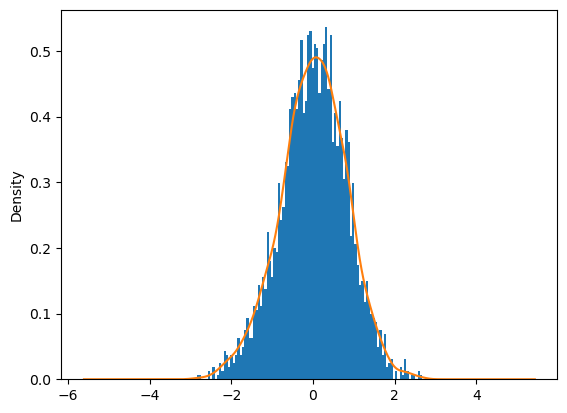

In [287]:
ax2 = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax2)

### Demand and Utility

**Budgets:** Get food budget for all households, then find median budget

In [288]:
xhat = ugd_result.predicted_expenditures()
#Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()
#Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

**Reference Prices:** Choose reference prices.  Here we chose the year 2015 and averaged prices across markets.

In [289]:
#Prices per kilogram:
pbar = ugd_p.mean(axis=1)
pbar = pbar.reset_index(level="u", drop=True) #Reset index so that 'j' becomes a column instead of part of a MultiIndex
pbar = pbar.reindex(ugd_result.beta.index) #Only use prices for goods we can estimate
#Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)
#Define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

**Demand as a function of prices:** Demand schedules for households with different budgets

Text(0.5, 0, 'Quantities of Beef Demanded')

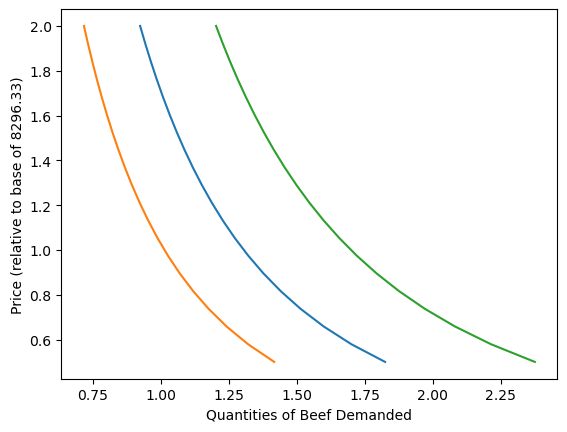

In [290]:
use = 'Beef'  #Good we want demand curve for

#Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

#Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

#Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

#Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

**Engel Curves:** Tracing how demand changes with budget

Text(0.5, 1.0, 'Engel Curves')

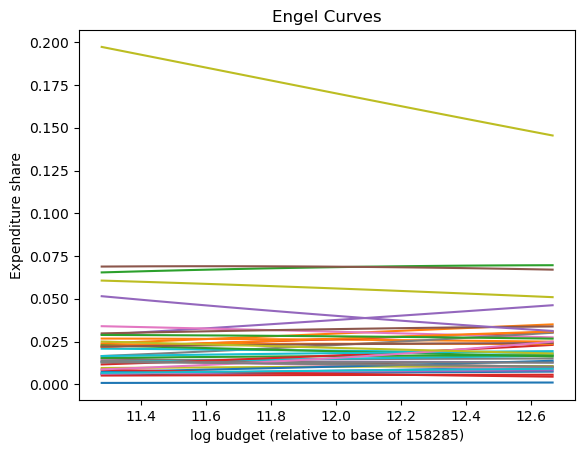

In [291]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

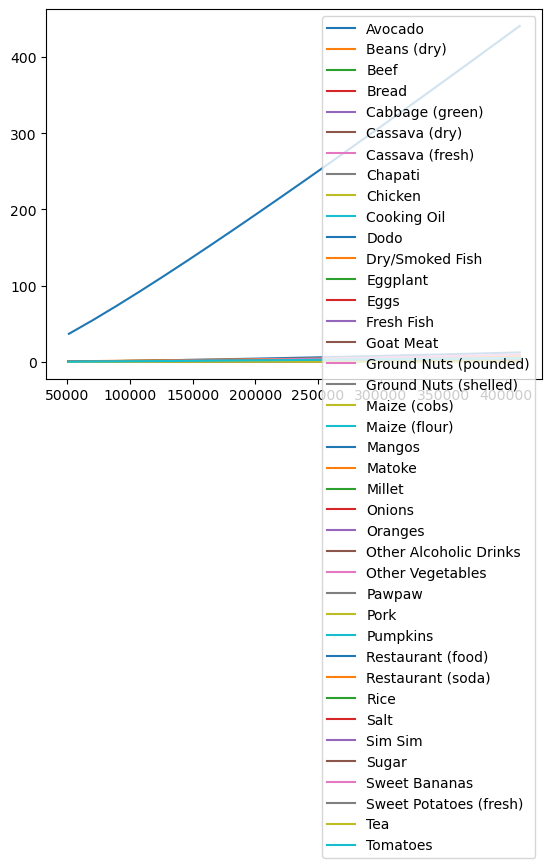

In [292]:
fig,ax = plt.subplots()

# Different budgets to evaluate demands at.
X = np.linspace(xbar.quantile(0.001),xbar.quantile(0.99),20)

ax.plot(X,[ugd_result.demands(x,pbar) for x in X])
ax.legend(ugd_result.demands(xref,pbar).index.tolist())

**Indirect Utility Function:**

Text(0.5, 1.0, 'Indirect Utility Function')

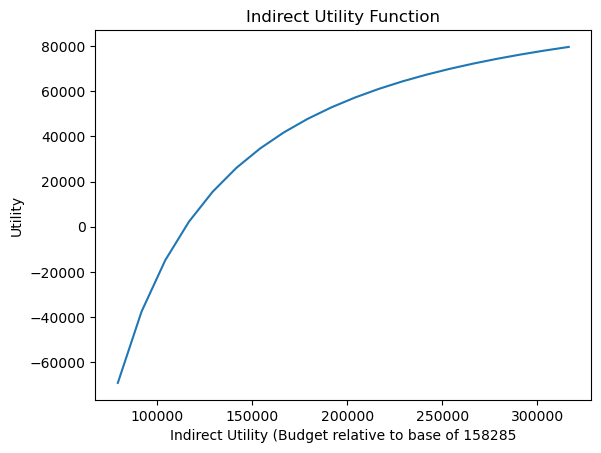

In [293]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')

### **[B]: Nutritional adequacy of diet**

In [294]:
#Get result saved above
ugd_result = cfe.read_pickle('Uganda.rgsn')
#Quantities in kg: expenditures divided by prices/kg
qhat = (xhat.unstack('j')/ugd_p.reset_index(drop=True, level="u").transpose()).dropna(how='all')
#Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

In [295]:
#...
use = ugd_fct.index.intersection(qhat.columns)
#...
nutrients = qhat[use]@ugd_fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household

n
Energy          134873.847039
Protein           5023.077436
Fiber             2093.700392
Folate           23899.372541
Calcium          24554.871729
Carbohydrate     22225.587319
Iron               833.326338
Niacin            1306.497423
Riboflavin          80.041428
Thiamin            109.263900
Vitamin A        26677.104260
Vitamin B-12       241.369874
Vitamin B-6        204.889975
Vitamin C        11463.946830
Zinc               540.237790
Magnesium            0.000000
Phosphorus           0.000000
Potassium            5.719018
Vitamin E            0.000000
Vitamin K            0.000000
dtype: float64

In [296]:
#Obtain recommended daily intake
ugd_z = ugd_z[ugd_rdi.columns.tolist()]
hh_rdi = ugd_z@ugd_rdi.T
#Make this a recommended WEEKLY intake
hh_rwi = hh_rdi*7
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)
nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()
#Display
nutrient_ratio

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc,Magnesium,Phosphorus,Potassium,Vitamin E,Vitamin K
i,t,m,,,,,,,,,,,,,,,,,,,,
H0010101,2015-16,Central,2.808476,5.256254,2.867136,2.794309,1.155151,6.405738,4.797428,4.297886,3.139595,4.202361,1.157189,5.940472,6.741199,4.412588,2.652361,0.0,0.0,0.000053,0.0,0.0
H0010201,2015-16,Central,1.893636,3.796955,2.002207,1.986903,0.697310,3.807601,2.804114,2.947649,2.107830,3.154753,0.922825,3.433830,4.797108,3.638866,1.986806,0.0,0.0,0.000050,0.0,0.0
H0010401,2015-16,Central,0.967321,2.096184,1.052092,0.892802,0.278882,1.453090,1.006839,1.408004,1.014840,1.464199,0.528043,1.517900,2.269957,2.091853,1.134317,0.0,0.0,0.000022,0.0,0.0
H0020801,2015-16,Central,2.649303,4.718890,2.761750,2.450177,0.963572,5.643898,3.399359,3.827744,2.780669,3.624191,1.103341,5.170408,5.541474,3.979872,2.275405,0.0,0.0,0.000046,0.0,0.0
H0020901,2015-16,Central,2.186671,4.215063,2.210750,2.021285,0.754575,4.492126,2.519259,3.272650,2.354191,3.141974,0.933549,4.295977,4.899198,3.546468,2.069101,0.0,0.0,0.000041,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H4300701,2015-16,Western,2.545225,4.995349,2.743961,2.546958,0.724687,5.403389,3.556793,3.866406,2.740480,3.843928,1.091538,5.815581,6.867345,5.580223,2.160837,0.0,0.0,0.000045,0.0,0.0
H4300801,2015-16,Western,2.109373,4.582785,2.376290,2.178005,0.478427,3.573225,2.195544,3.181442,2.257446,3.325345,1.063035,4.192968,5.988199,6.059644,1.996844,0.0,0.0,0.000037,0.0,0.0
H4300901,2015-16,Western,1.948792,3.108460,2.404841,1.811792,0.509039,4.481023,1.754954,2.639695,2.024472,2.804331,0.983887,2.862088,4.981918,4.415659,1.726181,0.0,0.0,0.000030,0.0,0.0


<Axes: >

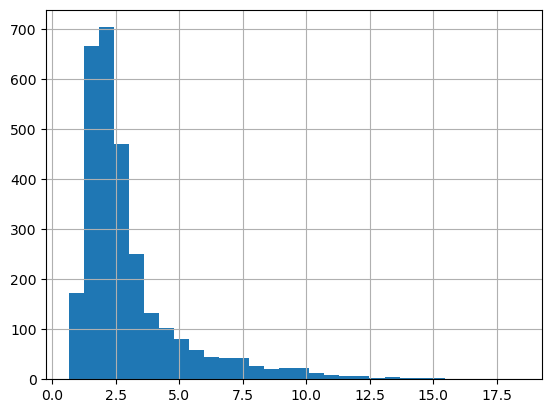

In [297]:
#Plot nutrient ratio for specific nutrient
%matplotlib inline
nutrient_ratio['Energy'].hist(bins=30)

### **[C]: Counterfactual experiments**